In [99]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path


from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM

from auctions.webutils import *

from scipy.stats import loguniform
import copy

import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Magma256
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import random

output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Get checkpoints from run names, and launch BRs

In [100]:
run_names = ['jun13_jun13_4_medium_speed-ppo_may31_23ppo_76-102',
       'jun13_jun13_3_medium_speed-ppo_no_ent_jun14ppo_76_no_ent-102',
       'jun13_jun13_0_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100',
       'jun13_jun13_4_high_speed-cfr_outcomemccfr_outcome-102',
       'jun13_jun13_3_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100',
       'jun13_jun13_1_medium_speed-ppo_no_ent_jun14ppo_76_no_ent-102',
       'jun13_jun13_1_base-ppo_no_ent_jun14ppo_76_no_ent_tremble_wall-101',
       'jun13_jun13_1_high_speed-cfr_outcomemccfr_outcome-102',
       'jun13_jun13_1_medium_speed-cfr_outcomemccfr_outcome-100',
       'jun13_jun13_3_high_speed-ppo_may31_23ppo_76-101']


checkpoints = []
for run in EquilibriumSolverRun.objects.filter(name__in=run_names):
    checkpoint = run.equilibriumsolverruncheckpoint_set.last()
    if checkpoint is not None:
        checkpoints.append(checkpoint)

In [101]:
run_name_to_nash_conv = dict()
for checkpoint in checkpoints:
    run_name_to_nash_conv[checkpoint.equilibrium_solver_run.name] = checkpoint.get_modal_eval().nash_conv

In [102]:
run_name_to_nash_conv

{'jun13_jun13_4_medium_speed-ppo_may31_23ppo_76-102': 213.45078750000005,
 'jun13_jun13_1_high_speed-cfr_outcomemccfr_outcome-102': 2.8999999999999915,
 'jun13_jun13_1_medium_speed-cfr_outcomemccfr_outcome-100': 1.5625,
 'jun13_jun13_3_high_speed-ppo_may31_23ppo_76-101': 10.849999999999994,
 'jun13_jun13_4_high_speed-cfr_outcomemccfr_outcome-102': 11.504999999999967,
 'jun13_jun13_1_medium_speed-ppo_no_ent_jun14ppo_76_no_ent-102': 0.0,
 'jun13_jun13_3_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100': 457.22749999999996,
 'jun13_jun13_1_base-ppo_no_ent_jun14ppo_76_no_ent_tremble_wall-101': 97.48,
 'jun13_jun13_0_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100': 498.1425,
 'jun13_jun13_3_medium_speed-ppo_no_ent_jun14ppo_76_no_ent-102': 3.2768816015625077}

In [ ]:
from open_spiel.python.examples.ubc_dispatch import *

for checkpoint in checkpoints:
    experiment_name = checkpoint.equilibrium_solver_run.experiment.name
    run_name = checkpoint.equilibrium_solver_run.name
    t = checkpoint.t
    configs = 'jun15_23'
    for br_player in range(2):
        dispatch_br_database(experiment_name, run_name, t, br_player, configs, submit=True, overrides='--total_timesteps 1_000_000')


# Make Configs

In [4]:
### CONFIG GENERATOR
base = yaml.safe_load(open('configs/ppo_may31_23/ppo_76.yml'))


In [5]:
N_CONFIGS = 50

configs = []

for _ in range(N_CONFIGS):
    x = copy.deepcopy(base)
    
    x['steps_per_batch'] = int(np.random.choice([64, 128]))
    x['num_minibatches'] = int(np.random.choice([4, 8]))
    x['update_epochs'] = int(np.random.choice([4, 8, 16]))
    x['learning_rate'] = float(np.random.choice([3e-5, 6e-6, 9e-5, 1e-4, 3e-4]))
    x['gae'] = bool(np.random.choice([True, False]))
    # x['gamma'] = float(np.random.uniform(0.8, 1.)) # WE DO NOT WANT THIS
    x['anneal_lr'] = bool(np.random.choice([True, False]))
    x['gae_lambda'] = float(np.random.uniform(0.94, 1.))
    x['clip_coef'] = float(loguniform.rvs(0.0003, .3, size=1)[0])
    x['clip_vloss'] = bool(np.random.choice([True, False]))
    x['entropy_coef'] = float(np.random.choice([1e-4, 1e-5, 1e-6, 0, 3e-5, 3e-6]))
    x['value_coef'] = float(loguniform.rvs(0.1, 1.3, size=1)[0])
    x['num_envs'] = int(np.random.choice([4, 8, 16]))
    x['normalize_advantages'] = bool(np.random.choice([True, False]))
    
    x['optimizer'] = random.choice(['adam', 'rmsprop', 'sgd'])
    optimizer_kwargs = dict()
    if x['optimizer'] == 'adam':
        beta1 = float(np.random.uniform(0.8, .9))
        beta2 = float(np.random.uniform(0.8, .999))
        optimizer_kwargs['betas'] = [beta1, beta2]
    elif x['optimizer'] == 'sgd':
        pass
    elif x['optimizer'] == 'rmsprop':
        pass
    else:
        raise ValueError()
    
    x['optimizer_kwargs'] = optimizer_kwargs
    x['max_grad_norm'] = float(np.random.uniform(0.1, 1)) 
      
    agent_kwargs = dict()
    agent_kwargs['activation'] = str(np.random.choice(['relu', 'tanh']))
    agent_kwargs['hidden_sizes'] = random.choice([
        [32, 32, 32], [64, 64, 64], [128, 128, 128],
    ])
    agent_kwargs['add_skip_connections'] = bool(np.random.choice([True, False]))
    agent_kwargs['use_torso'] = bool(np.random.choice([True, False]))
    
    x['agent_fn_kwargs'] = agent_kwargs
    
    configs.append(x) 

In [6]:
new_date = 'jun15_23'

!mkdir -p configs/{new_date}
for i, config in enumerate(configs):
    yaml.dump(config, open(f'configs/{new_date}/ppo_{i}.yml', 'w'))
    

# Load all of the relevant BRs

In [103]:
# Query
brs = BestResponse.objects.filter(name__contains='jun15_23')
print(f"Found {brs.count()} best responses")

Found 667 best responses


In [104]:
pks = []
for run_name in run_names:
    pk =  EquilibriumSolverRunCheckpoint.objects.filter(equilibrium_solver_run__name=run_name).get().pk
    pks.append(pk)

In [105]:
dfs = []
for pk in pks:
    try:
        checkpoint = EquilibriumSolverRunCheckpoint.objects.get(pk=pk)
        df = parse_run(checkpoint.equilibrium_solver_run)
        # Remove bad checkopints
        df = df.query(f't == {df["t"].value_counts().idxmax()}')
        dfs.append(df)
    except:
        print("WARN")

In [135]:
master_df = pd.concat((*dfs,))

In [136]:
master_df = master_df.query('~name.str.contains("tremble")')
master_df = master_df.query('~name.str.contains("modal")')
master_df = master_df.query('~name.str.contains("straightforward")')
master_df = master_df.query('name != ""')

In [137]:
master_df['br_player'] = master_df['name'].apply(lambda x: int(x[1])) # Hack

In [41]:
print(master_df['name'].nunique())
master_df['freq'] = master_df['name'].map(master_df['name'].value_counts())
# master_df = master_df.query('freq >= 4')
# del master_df['freq']
master_df['name'].nunique()

102


102

In [138]:
master_df['config'] = master_df['name'].apply(lambda x: x.split('/')[1])

In [139]:
master_df = master_df.query('player == br_player')

In [140]:
to_merge = master_df.groupby(['model', 'player'])['PositiveRegret'].max().to_frame().rename(columns={'PositiveRegret': 'MaxPositiveRegret'})

In [141]:
master_df = master_df.merge(to_merge, on=['model', 'player'])

In [143]:
sub_frames = []
for _, sub_df in master_df.query('not name.isnull() and player == br_player', engine='python').groupby(['model', 't']):
    sub_df = sub_df[['name', 'MaxPositiveRegret', 'Regret']].copy()
    sub_df['Δ to Best Known Response'] = sub_df['Regret'] - sub_df['MaxPositiveRegret']
    sub_df = sub_df[['name', 'Δ to Best Known Response']]
    sub_df['name'] = sub_df['name'].str.replace('_', ' ').str.strip()
    sub_frames.append(sub_df)
distance_frame = pd.concat(sub_frames)


In [98]:
# distance_frame.groupby('name')['Δ to Best Known Response'].mean().sort_values().loc['jan21/ppo 13']
master_df.query('config == "ppo_76" and model == "jun13_jun13_3_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100"')

,name,t,reward,player,Baseline,Regret,PositiveRegret,num_players,model,game,freq,br_player,config,MaxPositiveRegret
57,p0=jun15_23/ppo_76,5001216,368.027345,0,112.196669,255.830676,255.830676,2,jun13_jun13_3_base-ppo_no_ent_jun14ppo_76_no_e...,jun13/jun13_3_base.json,12,0,ppo_76,258.888487
195,p1=jun15_23/ppo_76,5001216,304.969122,1,86.309022,218.6601,218.6601,2,jun13_jun13_3_base-ppo_no_ent_jun14ppo_76_no_e...,jun13/jun13_3_base.json,10,1,ppo_76,258.888487


In [95]:
master_df.query('config == "ppo_76"').groupby('model').filter(lambda grp: len(grp) > 1).groupby('model')['Regret'].sum().to_frame().join(pd.Series(run_name_to_nash_conv, name='NashConv'))

,Regret,NashConv
model,,
jun13_jun13_0_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100,480.646842,498.142500
jun13_jun13_1_base-ppo_no_ent_jun14ppo_76_no_ent_tremble_wall-101,92.920875,97.480000
jun13_jun13_3_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100,474.490776,457.227500
jun13_jun13_3_high_speed-ppo_may31_23ppo_76-101,1.500255,10.850000
jun13_jun13_3_medium_speed-ppo_no_ent_jun14ppo_76_no_ent-102,-74.141748,3.276882


jun13_jun13_4_medium_speed-ppo_may31_23ppo_76-102                    213.450788
jun13_jun13_1_high_speed-cfr_outcomemccfr_outcome-102                  2.900000
jun13_jun13_1_medium_speed-cfr_outcomemccfr_outcome-100                1.562500
jun13_jun13_3_high_speed-ppo_may31_23ppo_76-101                       10.850000
jun13_jun13_4_high_speed-cfr_outcomemccfr_outcome-102                 11.505000
jun13_jun13_1_medium_speed-ppo_no_ent_jun14ppo_76_no_ent-102           0.000000
jun13_jun13_3_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100         457.227500
jun13_jun13_1_base-ppo_no_ent_jun14ppo_76_no_ent_tremble_wall-101     97.480000
jun13_jun13_0_base-ppo_no_ent_jun14ppo_76_no_ent_tremble-100         498.142500
jun13_jun13_3_medium_speed-ppo_no_ent_jun14ppo_76_no_ent-102           3.276882
Name: red, dtype: float64

# Plot the BRs

In [17]:
# # Only show those near the current defaults
# target_mean = distance_frame['Δ to Best Known Response'].mean()
# print(target_mean)
# distance_frame = distance_frame.groupby('name').filter(lambda x: x['Δ to Best Known Response'].mean() >= target_mean - 300)

In [144]:
distance_frame['median'] = distance_frame['name'].map(distance_frame.groupby('name')['Δ to Best Known Response'].median().sort_values(ascending=False))
distance_frame = distance_frame.sort_values('median')
del distance_frame['median']

[Text(0, 0, 'p1=jun15 23/ppo 35'),
 Text(1, 0, 'p1=jun15 23/ppo 9'),
 Text(2, 0, 'p1=jun15 23/ppo 44'),
 Text(3, 0, 'p1=jun15 23/ppo 26'),
 Text(4, 0, 'p1=jun15 23/ppo 36'),
 Text(5, 0, 'p1=jun15 23/ppo 13'),
 Text(6, 0, 'p1=jun15 23/ppo 34'),
 Text(7, 0, 'p1=jun15 23/ppo 10'),
 Text(8, 0, 'p1=jun15 23/ppo 37'),
 Text(9, 0, 'p1=jun15 23/ppo 15'),
 Text(10, 0, 'p1=jun15 23/ppo 33'),
 Text(11, 0, 'p0=jun15 23/ppo 37'),
 Text(12, 0, 'p0=jun15 23/ppo 10'),
 Text(13, 0, 'p1=jun15 23/ppo 41'),
 Text(14, 0, 'p0=jun15 23/ppo 9'),
 Text(15, 0, 'p0=jun15 23/ppo 35'),
 Text(16, 0, 'p0=jun15 23/ppo 13'),
 Text(17, 0, 'p0=jun15 23/ppo 36'),
 Text(18, 0, 'p0=jun15 23/ppo 34'),
 Text(19, 0, 'p0=jun15 23/ppo 33'),
 Text(20, 0, 'p0=jun15 23/ppo 26'),
 Text(21, 0, 'p0=jun15 23/ppo 15'),
 Text(22, 0, 'p0=jun15 23/ppo 44'),
 Text(23, 0, 'p1=jun15 23/ppo 18'),
 Text(24, 0, 'p0=jun15 23/ppo 28'),
 Text(25, 0, 'p1=jun15 23/ppo 40'),
 Text(26, 0, 'p0=jun15 23/ppo 41'),
 Text(27, 0, 'p0=jun15 23/ppo 40'),
 Tex

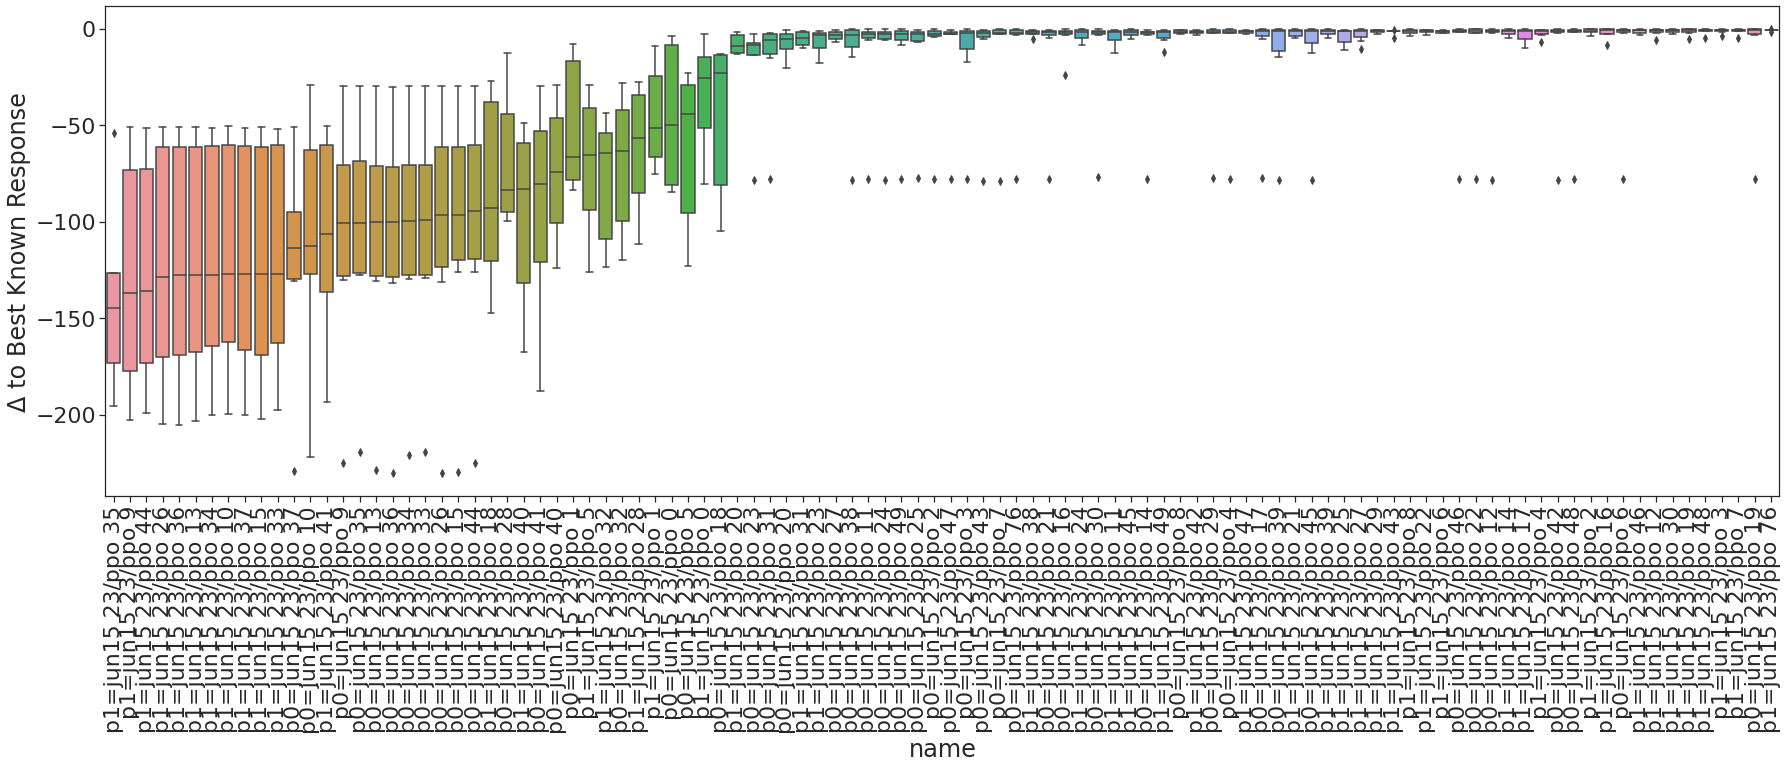

In [145]:
sns.set_theme(style="ticks", palette="pastel", font_scale=2)

# Draw a nested boxplot 
fig = plt.figure(figsize=(30, 9))
# sns.ecdfplot(hue="config", x="Δ to Best Known Response", data=distance_frame.sort_values('config'))
ax = sns.boxplot(x="name", y="Δ to Best Known Response", data=distance_frame)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# Viz what was good (BR edition)

In [20]:
# Step 1, group and score
scores = distance_frame.groupby('name').mean().rename(columns={'Δ to Best Known Response':'score'})

# Step 2, add actual parameters

In [21]:
configs = []

# We don't want to plot these, actually. THey used differed LRs which just mess with the trend
# for f in glob.glob('configs/jan18/*'):
#     config = yaml.safe_load(open(f))
#     num = int(f.replace('configs/jan18/ppo_', '').replace('.yml', ''))
#     config['name'] = f'jan18/ppo {num}'
#     configs.append(config)
for f in glob.glob('configs/jan23/*'):
    config = yaml.safe_load(open(f))
    num = int(f.replace('configs/jan23/ppo_', '').replace('.yml', ''))
    config['name'] = f'jan23/ppo {num}'
    configs.append(config)    

config_df = pd.json_normalize(configs)

In [22]:
merged_df = config_df.set_index('name').join(scores)
merged_df['agent_fn_kwargs.hidden_sizes'] = merged_df['agent_fn_kwargs.hidden_sizes'].apply(tuple)

In [29]:
TREAT_AS_BAR = ['num_envs', 'num_minibatches', 'steps_per_batch',  'agent_fn_kwargs.activation', 'agent_fn_kwargs.hidden_sizes', 'learning_rate', 'update_epochs', 'optimizer']

anneal_lr bool
clip_coef float64
clip_vloss bool
entropy_coef float64
gae bool
gae_lambda float64
learning_rate float64
max_grad_norm float64
normalize_advantages bool
num_annealing_updates object
num_envs int64
num_minibatches int64
optimizer object
steps_per_batch int64
target_kl object
update_epochs int64
value_coef float64
agent_fn_kwargs.activation object
agent_fn_kwargs.add_skip_connections bool
agent_fn_kwargs.hidden_sizes object
agent_fn_kwargs.use_torso bool
optimizer_kwargs.betas object


/tmp/ipykernel_6327/1661868839.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


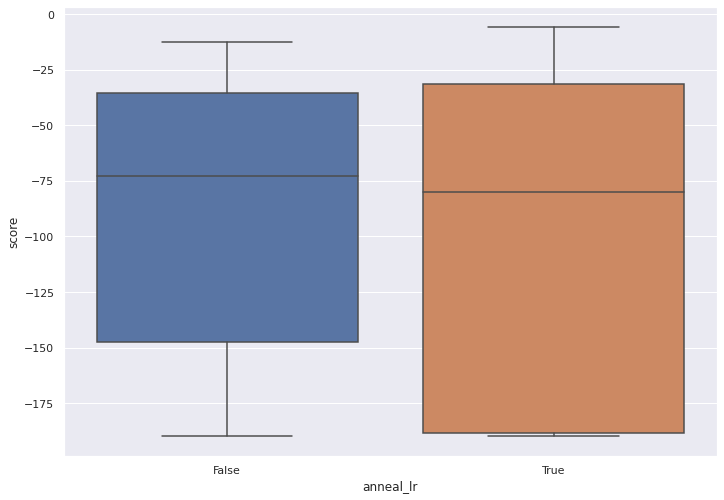

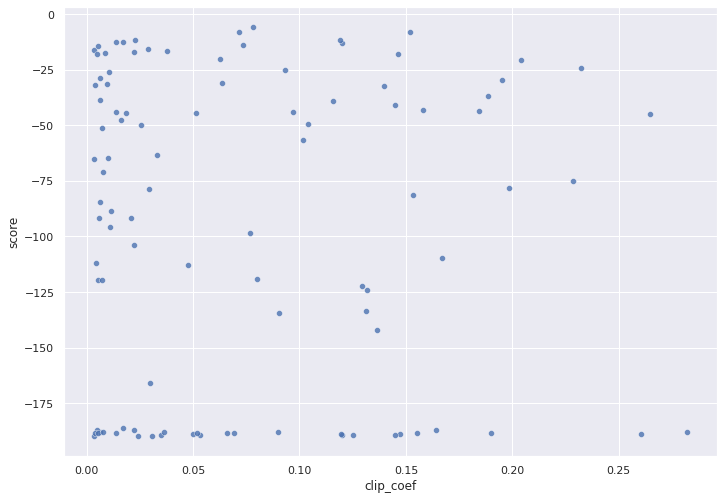

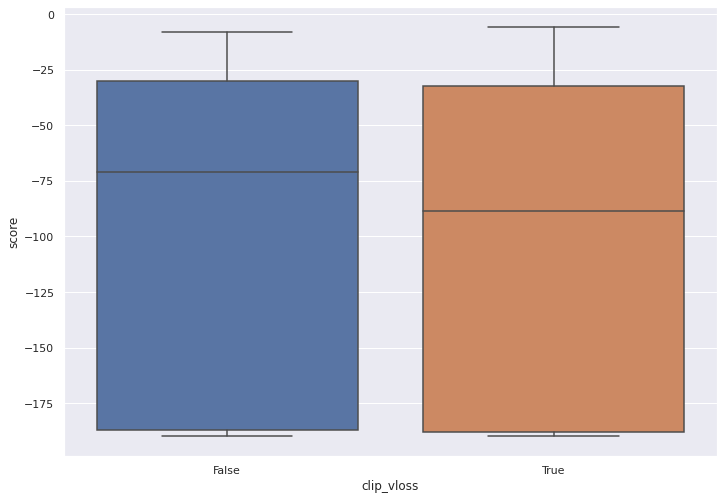

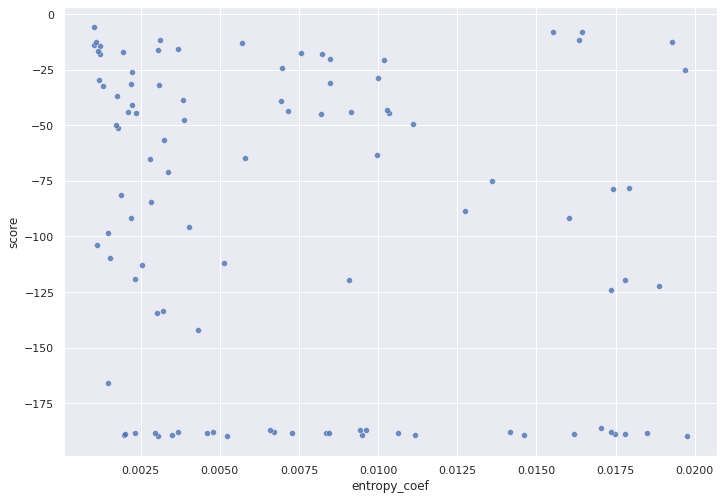

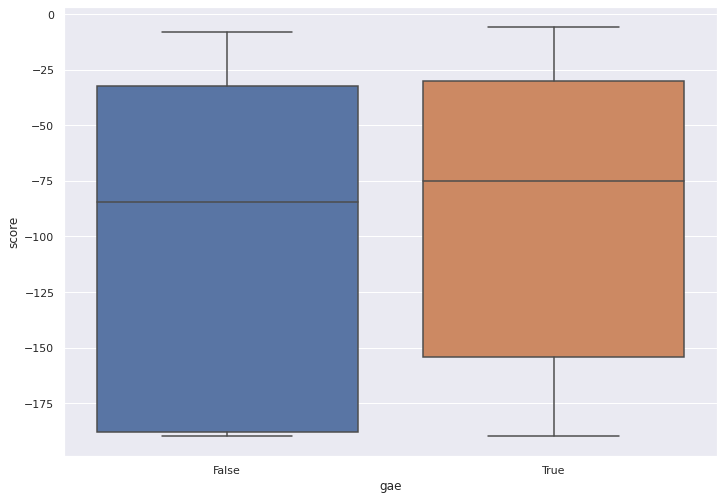

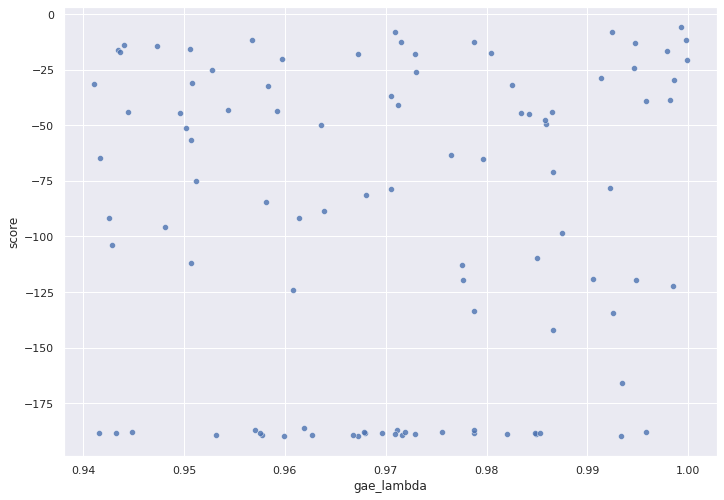

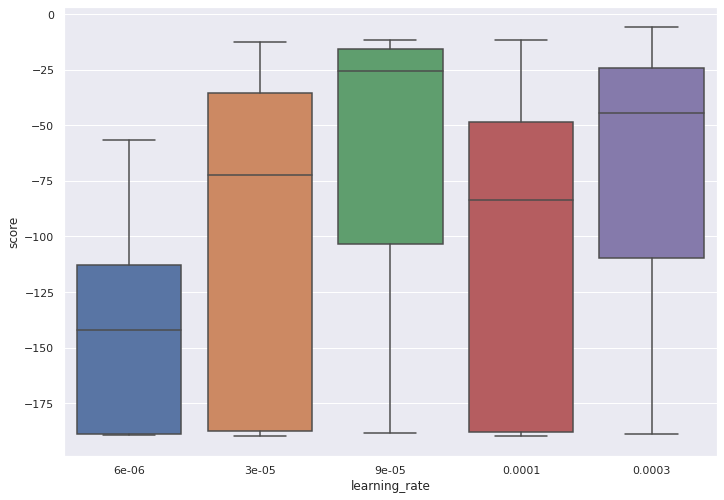

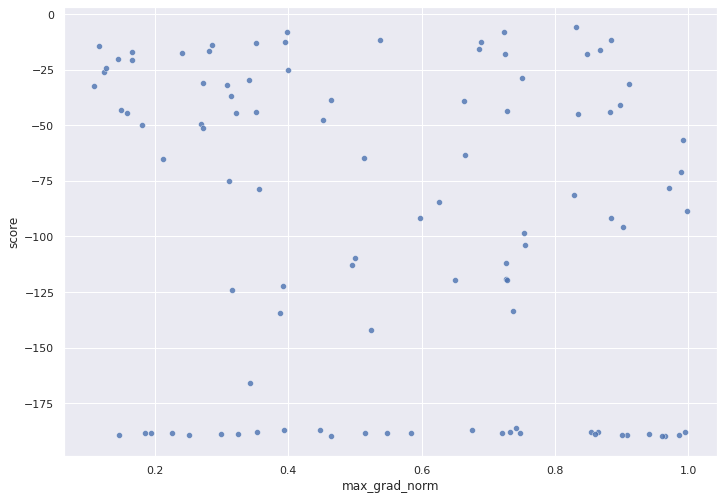

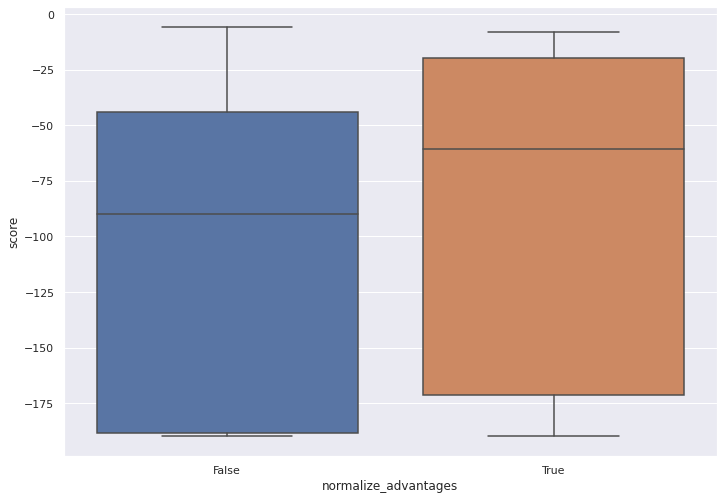

<Figure size 842.4x595.44 with 0 Axes>

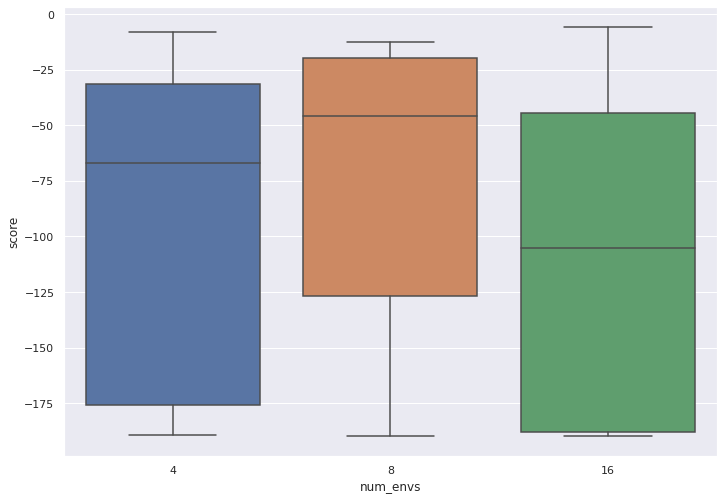

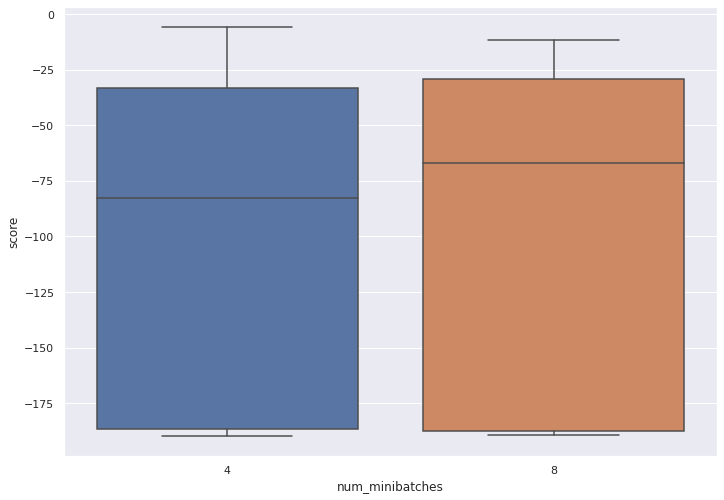

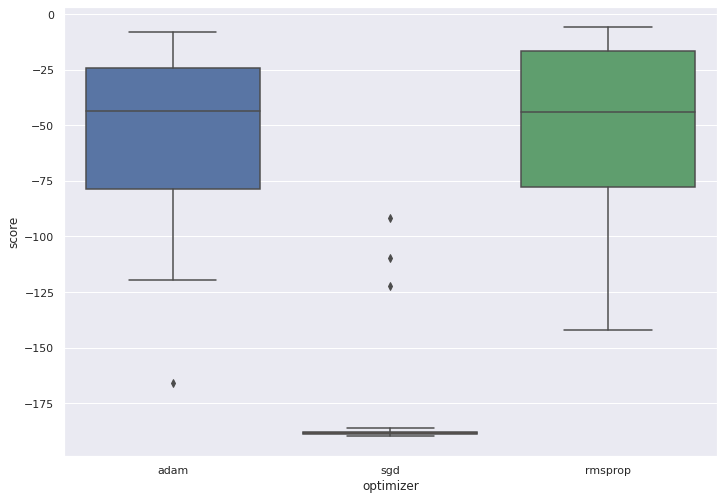

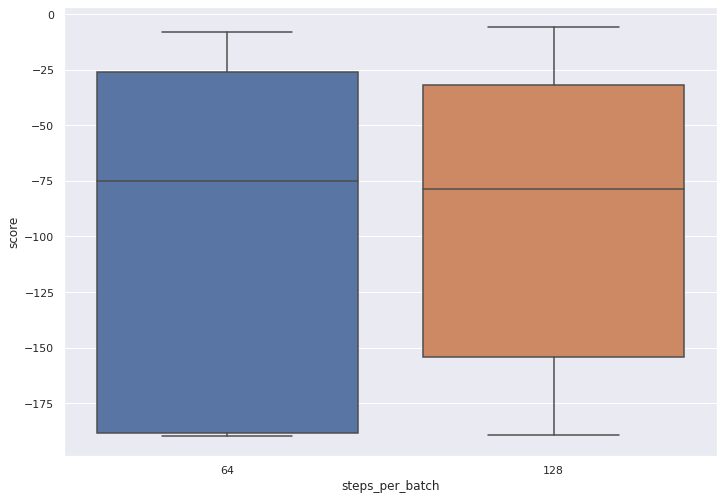

<Figure size 842.4x595.44 with 0 Axes>

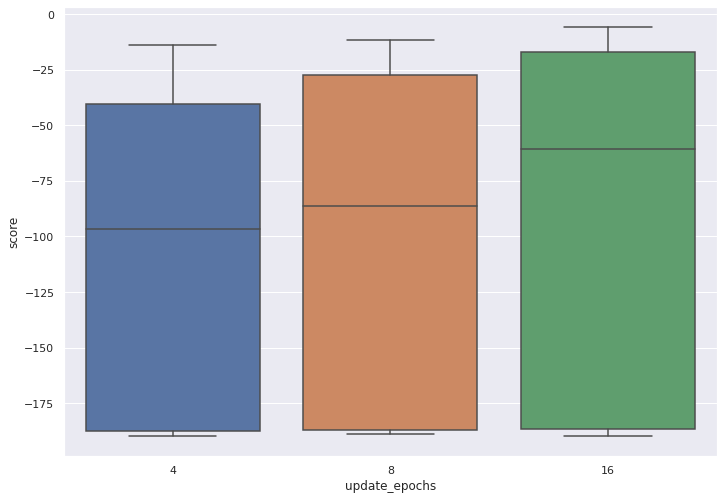

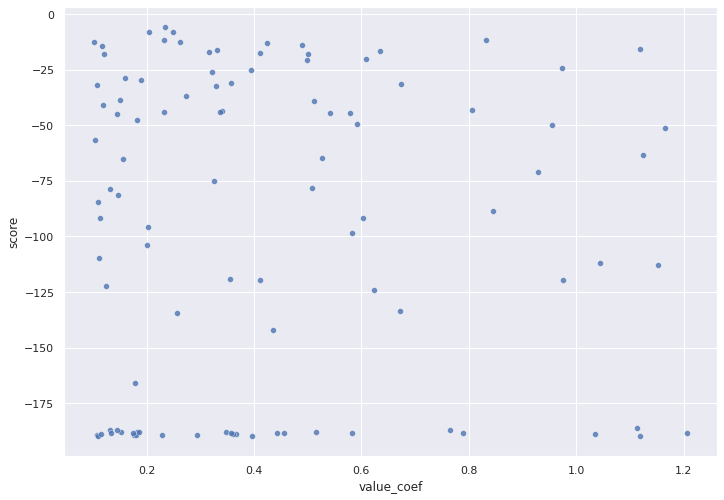

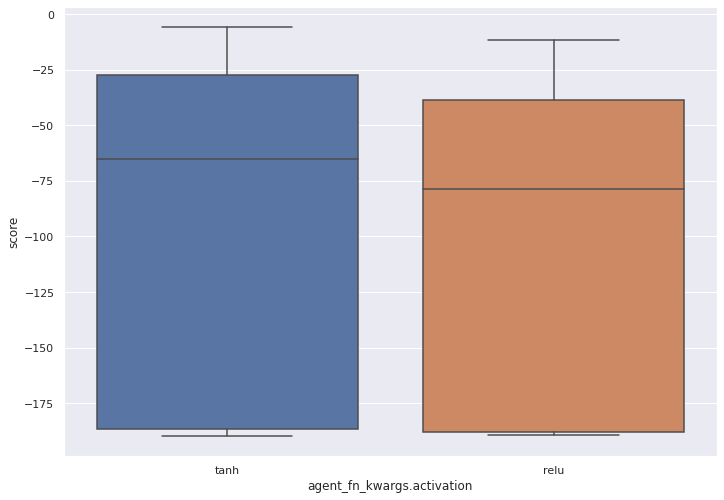

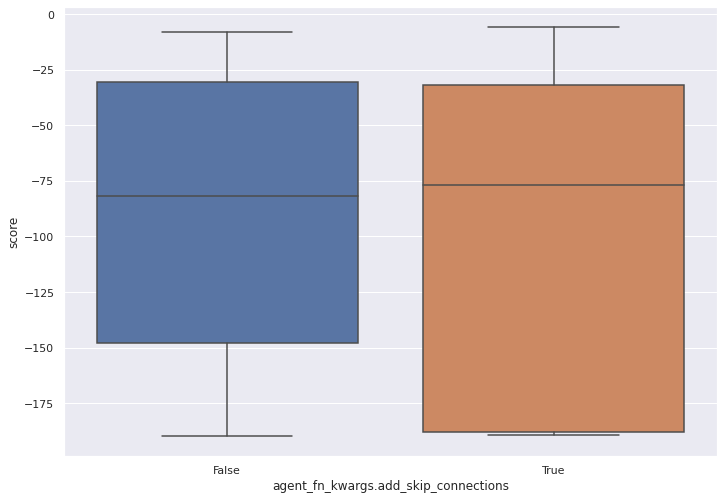

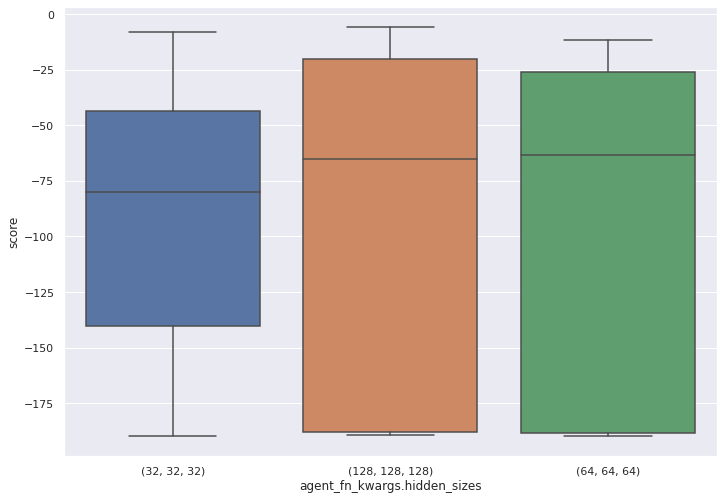

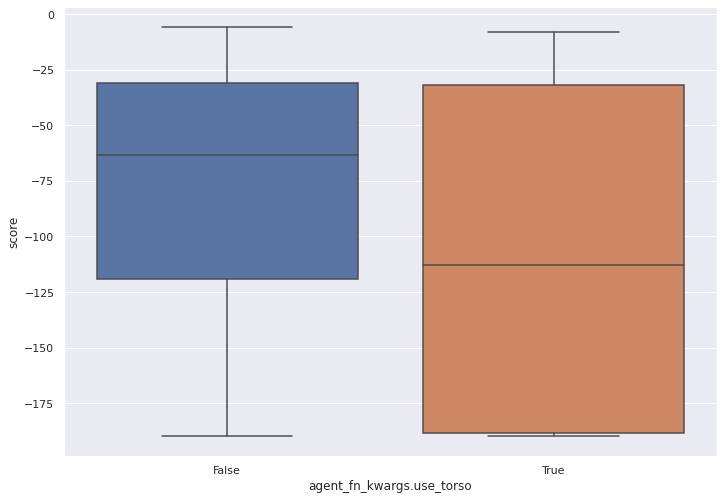

<Figure size 842.4x595.44 with 0 Axes>

In [30]:
# For each column, plot x axis is column and y axis is good
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
for c, t in merged_df.dtypes.items():
    if c in ['score', 'name', 'agent_fn', 'gamma', 'track_stats']:
        continue
    print(c,t)
    plt.figure()
    if str(t) == 'bool' or c in TREAT_AS_BAR:
        sns.boxplot(data=merged_df, x=c, y='score')

    elif str(t) == 'float64' or str(t) == 'int64':
        sns.scatterplot(data=merged_df, x=c, y='score', alpha=0.8)


In [195]:
merged_df.groupby('agent_fn_kwargs.hidden_sizes')['score'].mean()


agent_fn_kwargs.hidden_sizes
(32, 32)          -122.371904
(32, 32, 32)       -97.718835
(64, 64)          -103.477357
(64, 64, 64)       -50.898042
(128, 128)         -92.482026
(128, 128, 128)    -63.170029
Name: score, dtype: float64

# Visualize what parameters made a difference 

In [27]:
df = pd.read_csv('wandb_export_2023-01-18T11_54_49.617-08_00.csv') # Good runs
good_runs = df['Name'].apply(lambda x: x.split('-')[-2].split('_')[1]).astype(int).values

df = pd.read_csv('wandb_export_2023-01-18T12_02_35.537-08_00.csv') # All runs
all_runs = df['Name'].apply(lambda x: x.split('-')[-2].split('_')[1]).astype(int).values

bad_runs = set(all_runs) - set(good_runs)

In [39]:
df = pd.json_normalize(configs) # TODO: In general, you'd have to read configs from parsing the YAML files
df['agent_fn_kwargs.hidden_sizes'] = df['agent_fn_kwargs.hidden_sizes'].apply(tuple)
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

In [53]:
df['Good'] = False
df.loc[good_runs, 'Good'] = True
df['Good'].value_counts()

False    70
True     30
Name: Good, dtype: int64

In [87]:
TREAT_AS_BAR = ['num_envs', 'num_minibatches', 'steps_per_batch',  'agent_fn_kwargs.activation', 'agent_fn_kwargs.hidden_sizes', 'learning_rate', 'update_epochs']


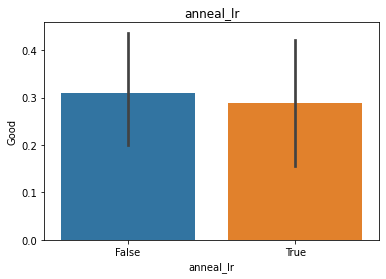

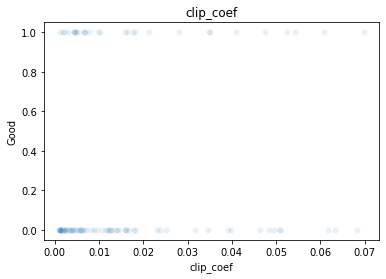

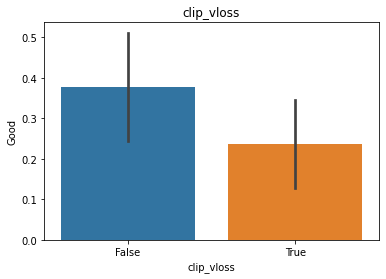

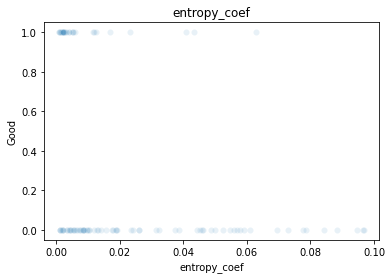

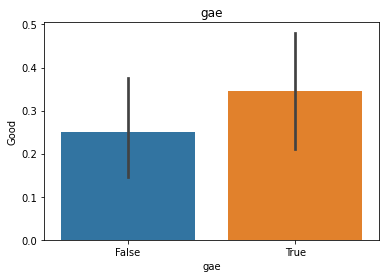

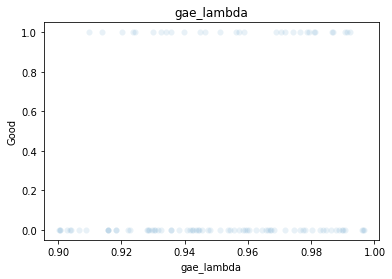

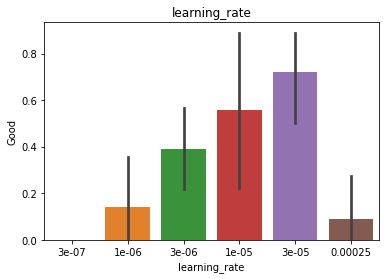

<Figure size 432x288 with 0 Axes>

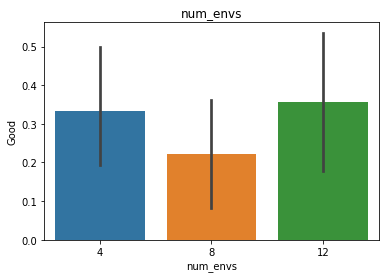

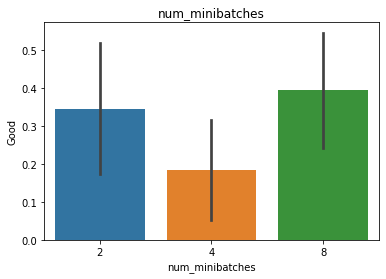

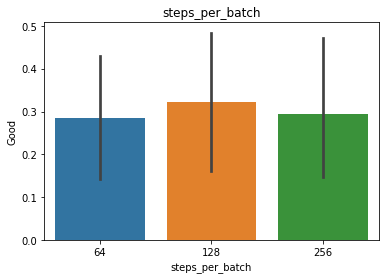

<Figure size 432x288 with 0 Axes>

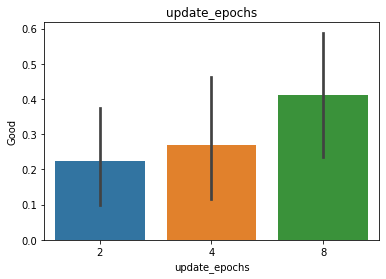

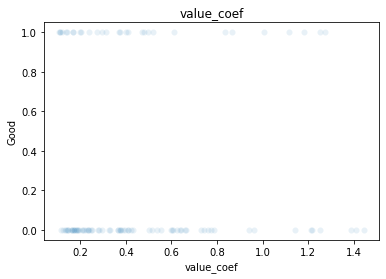

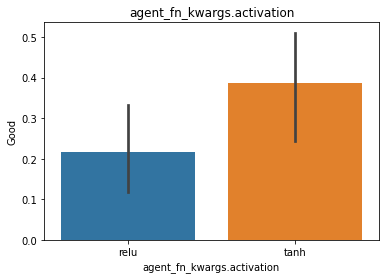

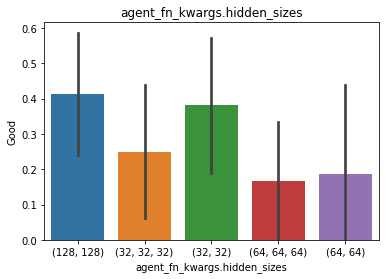

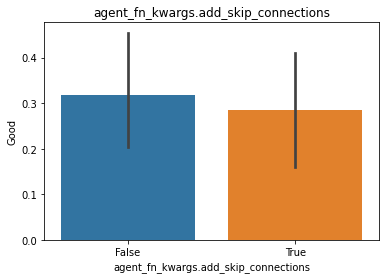

In [88]:
# For each column, plot x axis is column and y axis is good
import seaborn as sns
for c, t in df.dtypes.items():
    if c == 'Good':
        continue
    plt.figure()
    if str(t) == 'bool' or c in TREAT_AS_BAR:
        sns.barplot(data=df, x=c, y='Good')
        plt.title(c)
    elif str(t) == 'float64' or str(t) == 'int64':
        sns.scatterplot(data=df, x=c, y='Good', alpha=0.1)
        plt.title(c)


# Pick some runs randomly to BR against

In [95]:
df = pd.read_csv('wandb_export_2023-01-18T11_54_49.617-08_00.csv') # Good runs
good_runs = df['Name']
np.random.choice(good_runs, size=5, replace=False).tolist()

['jan12_confused_national_base-jan17ppo_46-100',
 'jan12_confused_national_base-jan17ppo_48-100',
 'jan12_confused_national_base-jan17ppo_15-100',
 'jan12_confused_national_base-jan17ppo_44-100',
 'jan12_confused_national_base-jan17ppo_42-100']